# Monte Carlo Methods

In [1]:
import numpy
import gym
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

## Blackjack Environment

In [2]:
env = gym.make('Blackjack-v0')
print(env.__doc__)

Simple blackjack environment

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.

    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).

    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.

    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.

    The observation of a 3-tuple of: the players c

In [3]:
env.action_space, env.observation_space

(Discrete(2), Tuple(Discrete(32), Discrete(11), Discrete(2)))

In [4]:
def custom_policy(observation):
    return 0 if observation[0] in [20, 21] else 1

In [5]:
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    observation = env.reset()
    while True:
        states.append(observation)
        action = policy(observation)
        actions.append(action)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            break

    return states, actions, rewards

generate_episode(custom_policy, env)

([(15, 6, False), (18, 6, False)], [1, 1], [0, -1])

## Monte Carlo Prediction

In [6]:
def monte_carlo_prediction(policy, env, n_episodes):
    V = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        states, _, rewards = generate_episode(policy, env)
        G = 0
        for t in range(len(states) -1, -1, -1):
            R = rewards[t]
            S = states[t]
            G += R
            if S not in states[:t]:
                N[S] += 1
                V[S] += (G - V[S]) / N[S]
    return V

V = monte_carlo_prediction(custom_policy, env, n_episodes=10000)

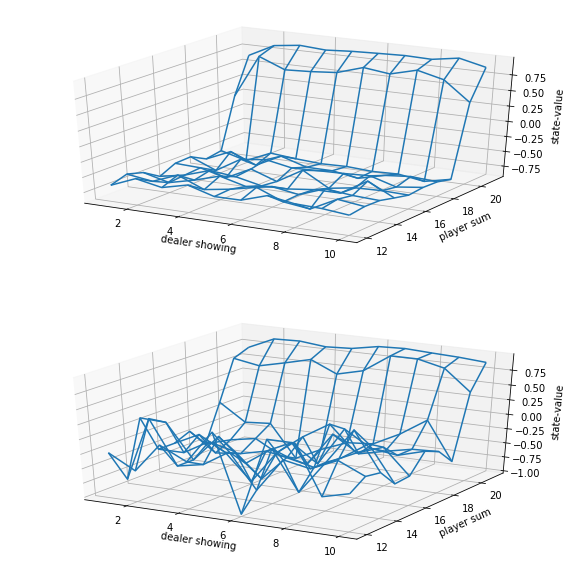

In [7]:
def plot_blackjack(V):
    player_states = numpy.arange(12, 21 + 1)
    dealer_states = numpy.arange(1, 10 + 1)
    ace_states = numpy.array([False, True])

    state_values = numpy.zeros((len(player_states),
                                len(dealer_states),
                                len(ace_states)))

    for i, player in enumerate(player_states):
        for j, dealer in enumerate(dealer_states):
            for k, ace in enumerate(ace_states):
                state_values[i, j, k] = V[player, dealer, ace]

    X, Y = numpy.meshgrid(dealer_states, player_states)

    fig = pyplot.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2 = fig.add_subplot(212, projection='3d')
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')

plot_blackjack(V)

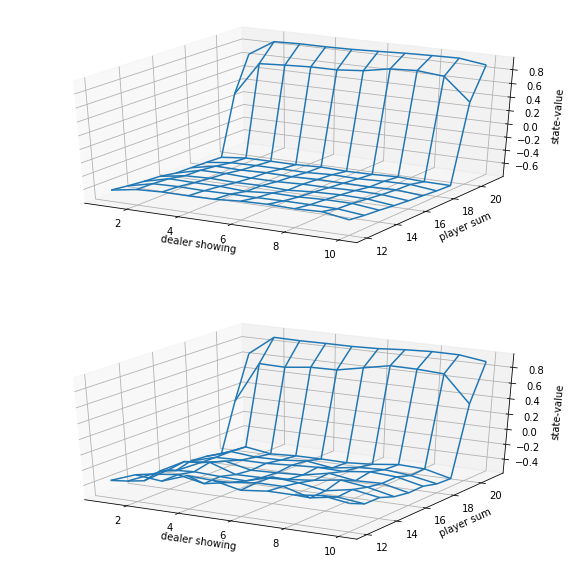

In [8]:
V_ = monte_carlo_prediction(custom_policy, env, n_episodes=500000)
plot_blackjack(V_)